In [15]:
import re
import glob 

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [16]:
num_hidden_nodes = [16, 32]
activations = 2*['tanh']
num_atoms = 40

In [17]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=0)

In [18]:
X_train_cycles = pd.read_parquet('X_'+'cycles'+'_train.parquet')
X_dev_cycles = pd.read_parquet('X_'+'cycles'+'_dev.parquet')
X_test_cycles = pd.read_parquet('X_'+'cycles'+'_test.parquet')

scaler = MinMaxScaler().fit(X_train_cycles)
    
X_train_cycles = pd.DataFrame(scaler.transform(
    X_train_cycles), columns=X_train_cycles.columns, index=X_train_cycles.index)
X_dev_cycles = pd.DataFrame(scaler.transform(
    X_dev_cycles), columns=X_dev_cycles.columns, index=X_dev_cycles.index)
X_test_cycles = pd.DataFrame(scaler.transform(
    X_test_cycles), columns=X_test_cycles.columns, index=X_test_cycles.index)

In [19]:
f_train = pd.read_parquet('y_train.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)
    
f_dev = pd.read_parquet('y_dev.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)
    
f_test = pd.read_parquet('y_test.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)

In [20]:
def get_features(features, num_hidden_nodes, activations, num_atoms):


    # %%
    network = '_'.join([str(x) for x in num_hidden_nodes])
    model_name = features+'--'+network+activations[0]
    
    f_type, n_hops, n_nei = model_name.split('-')[0], *re.findall('\d+', features)
    


    if f_type == 'paths':
        cols_hops = X_train_paths.columns[X_train_paths.columns.str.startswith(
            tuple(str(x)+'_(' for x in range(int(n_hops)+1)))]
        cols_neis = X_train_paths.columns[X_train_paths.columns.str.startswith(
            tuple(str(x)+'_[' for x in range(int(n_nei)+1)))]
        cols = cols_hops.to_list()+cols_neis.to_list()+['Atom']

        X_train = X_train_paths.loc[:, cols]
        X_dev = X_dev_paths.loc[:, cols]
        X_test = X_test_paths.loc[:, cols]
    else:
        cols_hops = X_train_cycles.columns[X_train_cycles.columns.str.startswith(
            tuple(str(x)+'_(' for x in range(int(n_hops)+1)))]
        cols_neis = X_train_cycles.columns[X_train_cycles.columns.str.startswith(
            tuple(str(x)+'_[' for x in range(int(n_nei)+1)))]
        cols = cols_hops.to_list()+cols_neis.to_list()+['Atom']
        X_train = X_train_cycles.loc[:, cols]
        X_dev = X_dev_cycles.loc[:, cols]
        X_test = X_test_cycles.loc[:, cols]        
    
    # %%

    
    X_train2 = X_train.to_numpy().reshape(-1, num_atoms, X_train.shape[-1])
    X_dev2 = X_dev.to_numpy().reshape(-1, num_atoms, X_dev.shape[-1])
    X_test2 = X_test.to_numpy().reshape(-1,  num_atoms, X_test.shape[-1])
    
    model = tf.keras.models.load_model('./results/'+model_name+'/checkpoints', compile = False)#, custom_objects={'loss': my_loss_fn})
    
    predictions = {}
    xs2 = [X_train2, X_dev2, X_test2]
    ys2 = [f_train, f_dev, f_test]
    xs = [X_train, X_dev, X_test]
    
    return(model, xs, xs2, ys2, n_hops, n_nei)


In [21]:
def predict(model, xs, xs2, ys2):
    predictions = {}
    for i, set in enumerate(['train', 'dev', 'test']):
        xvals = xs2[i]  # .to_numpy().reshape(-1, num_atoms, xs[i].shape[-1])
        y_pred2 = model.predict_on_batch(xvals)
        y_pred = pd.DataFrame(y_pred2.reshape(-1, 3),
                              columns=['x_hat', 'y_hat', 'z_hat'], index=xs[i].index)
        y_real = pd.DataFrame(ys2[i].reshape(-1, 3),
                              columns=['x', 'y', 'z'], index=xs[i].index)
        df_pred = pd.concat([y_real, y_pred], axis=1)
        predictions[set] = df_pred
    df_pred = pd.concat(predictions)
    df_pred['f'] = np.sqrt((df_pred[['x', 'y', 'z']]**2).sum(axis=1))
    df_pred['f_hat'] = np.sqrt((df_pred[['x_hat', 'y_hat', 'z_hat']]**2).sum(axis=1))

    return(df_pred)


In [32]:

def get_vectors(features_list):
    labels_list = []
    preds = {}
    preds_vector = {}
    shapes = {}
    for features in features_list:
        model, xs, xs2, ys2, n_hop, n_nei = get_features(features, num_hidden_nodes, activations, num_atoms)
        labels_list.append([n_hop, n_nei])
        preds[features] = predict(model, xs, xs2, ys2)
        print(features, xs[0].shape)
        mae = ((preds[features].loc[:, ['x', 'y', 'z']]).values - (preds[features].loc[:, ['x_hat', 'y_hat', 'z_hat']]).values)**2
        preds_vector[features] = pd.DataFrame(mae.reshape(-1))
        new_index = []
        for item in preds[features].index.to_list():
            item = list(item)
            a, b = item[1].split('--')
            c, e = a.split('_')
            item.extend([c, e, a, b])
            for d in ['x', 'y', 'z']:
                new_index.append(item + [d])
        preds_vector[features][['set', 'index', 'atom', 'atom_number', 'atom+number','structure', 'direction']] = new_index
        df = pd.concat(preds_vector).reset_index()
        df.columns = ['Features', 'level_1','MAE Forces', 'set', 'old_index', 'Atom', 'atom_number', 'atom+number', 'structure', 'Direction']
        df = df.drop('level_1', axis = 1)
        shapes[features] = xs[0].shape
    return(df, labels_list, preds_vector, preds, shapes, model, xs, xs2, ys2)

In [33]:
df, labels_list, preds_vector, preds, shapes, model, xs, xs2, ys2 = get_vectors(['cycles-exp4-coords2'])#, 'cycles-exp6-coords4'])

cycles-exp4-coords2 (30000, 421)


In [47]:
import time
ts = []
for _ in range(100):
    t0 = time.time()
    model.predict_on_batch(xs2[0])
    ts.append(time.time() - t0)

In [49]:
np.mean(np.array(ts)/80)

0.0011513288915157318

In [27]:
model.

In [10]:
pal = sns.color_palette('muted')


In [11]:
def plot_calibration(df_pred, ax, lims, bins, binrange, bbox, pad):
    sns.scatterplot(data =  df_pred.loc['test'], x = 'x', y = 'x_hat', ax = ax, color = pal[0], label = r'$f_x$')
    sns.scatterplot(data =  df_pred.loc['test'], x = 'y', y = 'y_hat', ax = ax, color = pal[1], label = r'$f_y$')
    sns.scatterplot(data =  df_pred.loc['test'], x = 'z', y = 'z_hat', ax = ax, color = pal[2], label = r'$f_z$')

    sns.lineplot(x = lims, y =  lims, color = pal[3], ax = ax)

    axins = inset_axes(ax, width="35%", height="35%", loc=2, bbox_to_anchor=bbox, bbox_transform=ax.transAxes, borderpad = pad)

    errs = df_pred.loc['test'].iloc[:, 0:-2].diff(axis = 1, periods = 3).abs().dropna(axis = 1).values.reshape(-1)

    sns.histplot(data = errs, ax = axins, stat = 'percent', bins = bins, binrange=binrange, color = pal[7])
    axins.set_xlabel('Absolute Error (eV/Å)', fontsize = 12)
    axins.set_ylabel('Percent', fontsize = 12)

    ax.legend(loc = 4, fontsize = 14)
    ax.set_xlabel(r'$f$ (eV/Å)', fontsize = 14)
    ax.set_ylabel(r'$\hat{f}$ (eV/Å)', fontsize = 14)
    #return ax

/home/sck/shafiro1/py_oenvs/tf/lib64/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



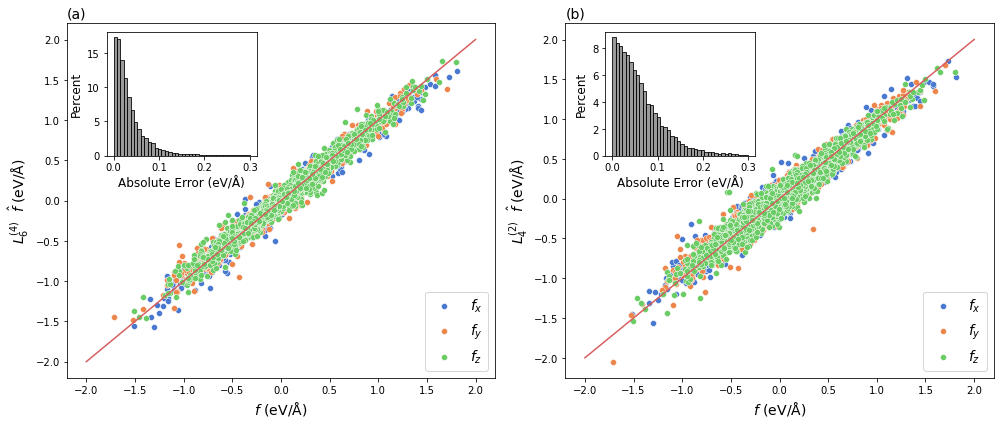

In [12]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize=(14, 6.0))

plot_calibration(preds['cycles-exp4-coords2'], axs[1], [-2., 2.], 40, (0,0.3), (0, 0.09, 1, 1), 4)
plot_calibration(preds['cycles-exp6-coords4'], axs[0], [-2., 2.], 40, (0,0.3), (0, 0.09, 1, 1), 4)
axs[0].set_title('(a)', loc = 'left', fontsize = 14)
axs[1].set_title('(b)', loc = 'left', fontsize = 14)
axs[0].set_ylabel(r'$L^{(4)}_6\ \ \hat{f}$ (eV/Å)', fontsize = 14)
axs[1].set_ylabel(r'$L^{(2)}_4\ \ \hat{f}$ (eV/Å)', fontsize = 14)
plt.tight_layout()
plt.savefig('figures/BTO-calibrations.pdf', bbox_inches='tight')
plt.savefig('figures/BTO-calibrations.svg', bbox_inches='tight')
plt.savefig('figures/BTO-calibrations.png', bbox_inches='tight', dpi = 200)


In [13]:
preds['cycles-exp4-coords2'][['x', 'y', 'z']].abs().mean().mean()

0.2341789

In [14]:
np.sqrt(df.groupby(['Features', 'set'])['MAE Forces'].describe()).round(3)

count   mean    std  min    25%    50%    75%  \
Features            set                                                      
cycles-exp4-coords2 dev    122.474  0.083  0.128  0.0  0.023  0.049  0.086   
                    test   124.419  0.081  0.119  0.0  0.022  0.048  0.085   
                    train  300.000  0.073  0.097  0.0  0.021  0.045  0.079   
cycles-exp6-coords4 dev    122.474  0.052  0.088  0.0  0.011  0.024  0.046   
                    test   124.419  0.051  0.090  0.0  0.011  0.023  0.045   
                    train  300.000  0.037  0.054  0.0  0.009  0.019  0.036   

                             max  
Features            set           
cycles-exp4-coords2 dev    1.033  
                    test   0.728  
                    train  0.482  
cycles-exp6-coords4 dev    0.411  
                    test   0.523  
                    train  0.294

In [32]:
np.sqrt(df.groupby(['Features', 'set'])['MAE Forces'].describe()).round(3)

count   mean    std  min    25%    50%    75%  \
Features            set                                                      
cycles-exp4-coords2 dev    122.474  0.083  0.128  0.0  0.023  0.049  0.087   
                    test   124.419  0.082  0.120  0.0  0.023  0.048  0.085   
                    train  300.000  0.073  0.097  0.0  0.021  0.045  0.079   
cycles-exp6-coords4 dev    122.474  0.052  0.088  0.0  0.011  0.024  0.047   
                    test   124.419  0.052  0.091  0.0  0.011  0.024  0.046   
                    train  300.000  0.037  0.055  0.0  0.009  0.020  0.037   

                             max  
Features            set           
cycles-exp4-coords2 dev    1.016  
                    test   0.726  
                    train  0.481  
cycles-exp6-coords4 dev    0.411  
                    test   0.510  
                    train  0.296

In [ ]:
df_pred = preds['paths-exp4-coords2']

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(10, 6.67))

sns.scatterplot(data =  df_pred.loc['test'], x = 'x', y = 'x_hat', ax = axs, color = pal[0], label = r'$f_x$')
sns.scatterplot(data =  df_pred.loc['test'], x = 'y', y = 'y_hat', ax = axs, color = pal[1], label = r'$f_y$')
sns.scatterplot(data =  df_pred.loc['test'], x = 'z', y = 'z_hat', ax = axs, color = pal[2], label = r'$f_z$')

sns.lineplot(x = [-3.25, 3.25], y =  [-3.25, 3.25], color = pal[3], ax = axs)

axins = inset_axes(axs, width="35%", height="40%", loc=2, bbox_to_anchor=(0, 0.12, 1, 1), bbox_transform=axs.transAxes, borderpad = 5)#,)

sns.histplot(data = (df_pred['f'] - df_pred['f_hat']).abs().loc['test'], ax = axins, stat = 'percent', bins = 30, binrange=(0,0.5), color = pal[7])
axins.set_xlabel('MAE (eV/Å)', fontsize = 12)
axins.set_ylabel('Percent', fontsize = 12)

axs.legend(loc = 4, fontsize = 14)
axs.set_xlabel(r'$f$ (eV/Å)', fontsize = 14)
axs.set_ylabel(r'$\hat{f}$ (eV/Å)', fontsize = 14)



In [ ]:
df_pred = preds['paths-exp6-coords4']

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(10, 6.67))

sns.scatterplot(data =  df_pred.loc['test'], x = 'x', y = 'x_hat', ax = axs, color = pal[0], label = r'$f_x$')
sns.scatterplot(data =  df_pred.loc['test'], x = 'y', y = 'y_hat', ax = axs, color = pal[1], label = r'$f_y$')
sns.scatterplot(data =  df_pred.loc['test'], x = 'z', y = 'z_hat', ax = axs, color = pal[2], label = r'$f_z$')

sns.lineplot(x = [-3.25, 3.25], y =  [-3.25, 3.25], color = pal[3], ax = axs)

axins = inset_axes(axs, width="35%", height="40%", loc=2, bbox_to_anchor=(0, 0.12, 1, 1), bbox_transform=axs.transAxes, borderpad = 5)#,)

sns.histplot(data = (df_pred['f'] - df_pred['f_hat']).abs().loc['test'], ax = axins, stat = 'percent', bins = 30, binrange=(0,0.3), color = pal[7])
axins.set_xlabel('MAE (eV/Å)', fontsize = 12)
axins.set_ylabel('Percent', fontsize = 12)

axs.legend(loc = 4, fontsize = 14)
axs.set_xlabel(r'$f$ (eV/Å)', fontsize = 14)
axs.set_ylabel(r'$\hat{f}$ (eV/Å)', fontsize = 14)


In [ ]:
np.abs(f_train.reshape(-1, 3)).mean()

In [ ]:
df.groupby(['Features', 'set'])['MAE Forces'].describe()

In [ ]:
all_models = [x.split('--')[0].split('/')[-1] for x in glob.glob('./results/*') if '16_32tanh' in x]

In [ ]:
df, labels_list, preds_vector, preds, shapes = get_vectors(all_models)

In [ ]:
all_models

In [ ]:
df_shapes = pd.DataFrame(shapes).T
df_shapes[1].to_csv('shapes.csv')

In [ ]:
df_all = df.groupby(['Features', 'set'])['MAE Forces'].describe()
df_all.to_csv('errors.csv')

In [ ]:
df_all.loc['paths-exp']